**Guess the country of temples from its pictures**

# Abstract

This notebook presents the results of creating a predicitive model to tell from which country a temple is given its photograph.

The provided dataset is a zip file containing pictures of churches, mosques, monasteries and temples. The files are organized in subfolders named by the country where they are based.

Transfer Learning from a pre-trained ResNet is used in order to speedup the process of training while leveraging a state-of-the-art image model and working around with a small imbalanced dataset.

The model is estimated to have different accuracies for each country. Armenia is the worst performance (accuracy around null) while the best performance are for Russia, Germany and Thailand (accuracy around flawless). Other countries have intermediary performance (accuracy around 75%).

The model may be improved later with additional training on a larger and better balanced dataset of annotated images.

# Dependencies 

This work relies on:
- Python
- PyTorch
- Google Drive (to access dataset)
- GitLab (to import custom tools created for this project)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

Below we import custom tools made specifically for the present work.

In [2]:
GITLAB_TOKEN = 'DuYj_iSqRGrYtybZLMRs'
GITLAB_PROJECT = 'diogo-dutra-2'
GITLAB_OWNER = 'screening'
GITLAB_URL = f'https://gitlab-ci-token:{GITLAB_TOKEN}' + \
              f'@git.toptal.com/{GITLAB_OWNER}/{GITLAB_PROJECT}.git'

MODULE_DESTINATION = 'repo'

!rm -rf $GITLAB_PROJECT
!rm -rf $MODULE_DESTINATION
!git clone $GITLAB_URL
!mv $GITLAB_PROJECT $MODULE_DESTINATION


from repo.dataset.churches_dataset import ChurchesDataset, stratified_split
from repo.pytorch_boilerplate.plots import plot_confusion_matrix
import repo.pytorch_boilerplate.transforms as my_transforms
from repo.pytorch_boilerplate.trainer import (
    TransferLearning, TrainerClassifier, Metrics
)

Cloning into 'diogo-dutra-2'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 273 (delta 37), reused 0 (delta 0), pack-reused 223
Receiving objects: 100% (273/273), 38.02 KiB | 208.00 KiB/s, done.
Resolving deltas: 100% (132/132), done.


# Dataset

The zip file containing the photos from the provided link was previously unzipped to a Google Drive. This procedure was performed in order to avoid downloading multiple times the original zip file during the development of the present notebook.

In [3]:
drive.mount('/content/drive', force_remount=True)

folder = './drive/MyDrive/train' # folder containing the provided images

!ls $folder

Mounted at /content/drive
Armenia    Hungary+Slovakia+Croatia  Malaysia+Indonesia  Spain
Australia  Indonesia-Bali	     Portugal+Brazil	 Thailand
Germany    Japan		     Russia


In [4]:
raw_dataset = ChurchesDataset(folder)
print(len(raw_dataset), 'images in dataset.')

n_countries = len(raw_dataset.countries.keys())
print(n_countries, 'countries in dataset')

694 images in dataset.
11 countries in dataset


## Plot Samples

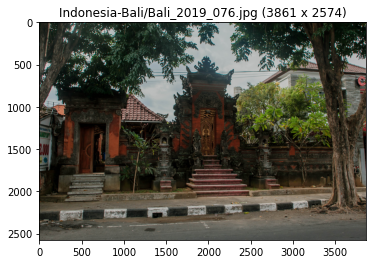

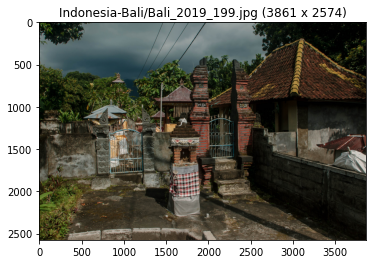

In [5]:
samples = 2

# indices = np.random.choice(len(raw_dataset), samples)
indices = range(samples)

for idx in indices:
  plt.figure()
  raw_dataset.plot_church(idx)

The images have different sizes. Some of them are not very well centered, as the ones shown below. 

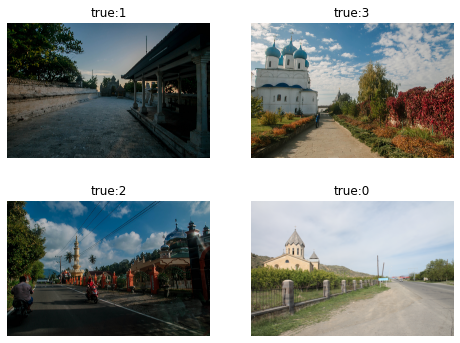

In [6]:
photos = ['Armenia_095', 'Serpuhov_090',
          'Bali_2019_679', 'Sabang_051',
          ]

ds = ChurchesDataset(folder, include=photos)

plt.figure(figsize=(8,6))
ds.plot_booth(range(len(ds)), cols=2)

The samples shown above would lead to a potential loss of valuable features when we apply a square crop at the center of the image, as shown below.

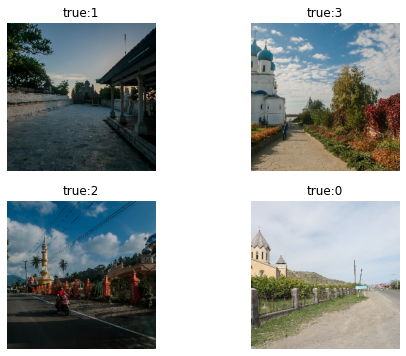

In [7]:
ds = ChurchesDataset(folder, include=photos,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomResizedCrop(256, scale=(0.8, 1.0), ratio=(1.,1.)),
            transforms.CenterCrop(244),
        ]))
plt.figure(figsize=(8,6))
ds.plot_booth(range(len(ds)), cols=2)

## Best Square Crop

In order to improve the square crop to maximize the presence of relevant features from the original image, we detect which region contains most of the temple/church/monasteru/stupa and make a square crop there.

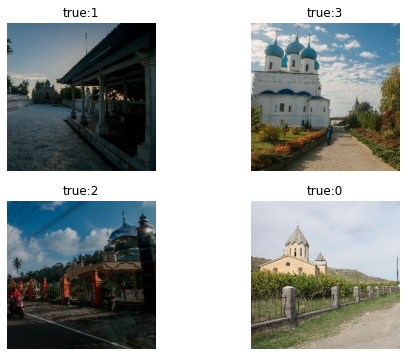

In [8]:
# ResNet18 idx_to_class dict based on ImageNet as listed at:
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

sacred_class_weight = {
# class_id: class_weight
    497: 1, # church
    668: 1, # mosque
    663: 1, # monastery
    832: 1, # stupa
    }

sacred_crop = my_transforms.BestSquareCrop(sacred_class_weight)

ds = ChurchesDataset(folder, include=photos,
        transform=transforms.Compose([
            transforms.ToTensor(),
            sacred_crop,
            transforms.RandomResizedCrop(256, scale=(0.8, 1.0), ratio=(1.,1.)),
            transforms.CenterCrop(244),
        ]))
plt.figure(figsize=(8,6))
ds.plot_booth(range(len(ds)), cols=2)

As shown above, the samples are better centered now than the ones from the previous section.

## Data Augmentation

The dataset size is quite small. Therefore, Data Augmentation is going to be applied as a regularization procedure in order to avoid overfitting.

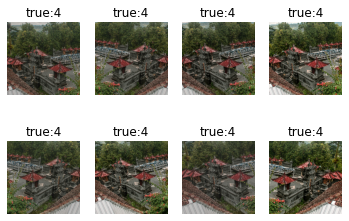

In [9]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    sacred_crop,
    transforms.RandomRotation(3, expand=False),
    
    # resize to ResNet input dimensions with some minor random crop
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0), ratio=(1.,1.)),
    transforms.RandomCrop((224, 224)),

    transforms.ColorJitter(brightness=.1, contrast=.2, saturation=.1, hue=.01),
    transforms.RandomHorizontalFlip(),

    my_transforms.GaussianNoise(std=1e-3),
    my_transforms.Clip(),
    ])

augmented_dataset = ChurchesDataset(folder, transform=train_transform)

idx = 20
indices = [idx] * 8
augmented_dataset.plot_booth(indices)

As seen above, the data augmentation is performing some small random modifications to the input images.

## Split

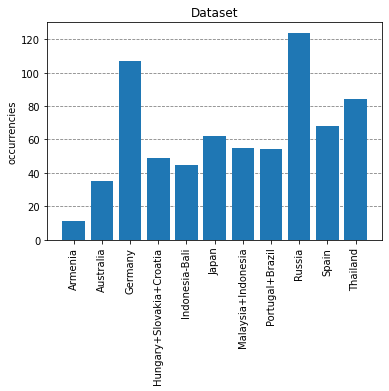

In [10]:
raw_dataset.plot_occurrencies()

The dataset is highly imbalanced. For this reason, the test and validation dataset are going to use the stratification technique in order to ensure a fixed amount of samples per country.

As a result, the training dataset will be the leftover after these two stratifications.

In [11]:
stratified_k = 4

test_dataset,  train_dataset = stratified_split(augmented_dataset,
                                                # shuffle=True,
                                                k=stratified_k)
valid_dataset, train_dataset = stratified_split(train_dataset,
                                                # shuffle=True,
                                                k=stratified_k)

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    sacred_crop,
    transforms.Resize((224, 224)),
    ])

for ds in [valid_dataset, test_dataset]:
  ds.transform = valid_transform
  

print( 'DATASET\t SIZE')
print(f' total \t {len(augmented_dataset)}')
print(f' test  \t {len(test_dataset)}')
print(f' valid \t {len(valid_dataset)}')
print(f' train \t {len(train_dataset)}')

DATASET	 SIZE
 total 	 694
 test  	 44
 valid 	 44
 train 	 606


## Weights

In order to compensate for the imbalanced training dataset, the loss function further down will be set with class weights inversely proportional to the occurrencies of each country.

In [12]:
countries = [augmented_dataset.countries[i] for i in range(n_countries)]
weights = [1 / augmented_dataset.counts[country] for country in countries]

print('WEIGHT  COUNTRY')
for country, weight in zip(countries, weights):
  print('{:.3f}  '.format(weight), country)

WEIGHT  COUNTRY
0.091   Armenia
0.029   Australia
0.009   Germany
0.020   Hungary+Slovakia+Croatia
0.022   Indonesia-Bali
0.016   Japan
0.018   Malaysia+Indonesia
0.019   Portugal+Brazil
0.008   Russia
0.015   Spain
0.012   Thailand


## Dataloaders


In [13]:
# Dataloaders

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=4)

valid_batch = min(len(valid_dataset), batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=valid_batch)

test_batch = min(len(test_dataset), batch_size)
test_loader = DataLoader(test_dataset, shuffle=False,
                        batch_size=test_batch)

# Model 

The predictive model is an image classifier, since we need to tell output a country (class) from an input image.

## Transfer Learning

The model is derived from Resnet18 Convolutional Neural Network classifier using the Transfer Learning technique. This choice speeds up the trainig step while compensating for the small dataset size, especially considering that it was trained with some classes derived from temples variations (churches, mosques, monasteries and stupas).

The 18 number of layers is the smallest version of available ResNet options. It was chosen the less complex model in order to avoid overfitting, considering that the provided dataset is quite small.

The output layer of the pre-trained neural network needs to be changed to 11 (countries), since ResNet was originally designed for ImageNet competition with 1000 classes. 

In [14]:
model = TransferLearning(num_target_classes = n_countries,
                 pretrained_model = models.resnet18(pretrained=True),
                )

Here is just a sanity check to assert that the model is correcly processing the input size and providing the expected output size.


In [15]:
input = torch.randn((16, 3, 244, 244))

output = model(input)
print(output.shape)

torch.Size([16, 11])


## Trainer

The trainer section is the PyTorch Boilerplate. In other words, this piece of code is very similar across many image classification projects with little if any modification.

In [16]:
trainer = TrainerClassifier(model,
              optimizer = lambda x: torch.optim.Adam(x, lr=3e-5))

In [17]:
trainer.run(train_loader, valid_loader, max_epochs = 20, early_stop_epochs = 3)

 epoch  train_loss  valid_loss  saved  precision  recall  F1  accuracy
     1      2.0177      1.6621      √        35%     50% 40%       50%


     2      1.3335      1.3120      √        47%     61% 53%       61%


     3      1.0041      1.1360      √        69%     68% 63%       68%


     4      0.8630      1.0420      √        71%     73% 68%       73%


     5      0.6860      1.0004      √        75%     75% 71%       75%


     6      0.6389      1.0511               75%     73% 69%       73%


     7      0.5319      1.0164               64%     70% 66%       70%


     8      0.4488      1.0879               68%     70% 66%       70%


     9      0.4273      0.9924      √        70%     70% 66%       70%


    10      0.3968      1.1335               74%     73% 68%       73%


    11      0.2804      1.0268               69%     75% 70%       75%


    12      0.3017      1.1998               69%     68% 64%       68%


    13      0.2193      1.0554               66%     68% 64%       68%


    14      0.2474      1.1399               68%     68% 64%       68%
Training time (H:MM:SS): 1:16:54


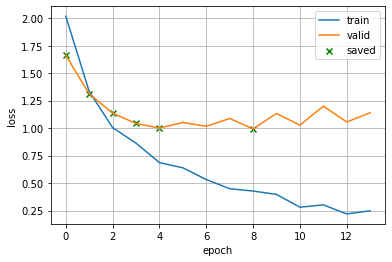

In [19]:
trainer.plot_losses()

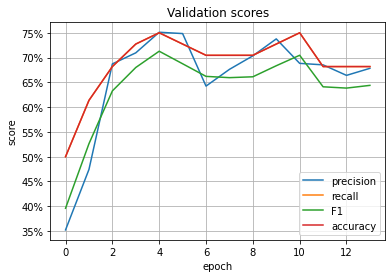

In [20]:
trainer.metrics.plot()
_ = plt.title('Validation scores')

# Performance

The test dataset is used to evaluate the performance of the trained model.

Considering that the test dataset was never seen by our model, the performance calculated in the next subsections are the expected one for all new pictures.

In [21]:
y_pred, y_true = trainer.predict(test_loader, return_targets=True)

## Metrics

In [22]:
metrics = Metrics()
metrics(y_true, y_pred, verbose=True)

precision	69%
   recall	70%
       F1	67%
 accuracy	70%


The performance is not bad, especially considering that there are 11 options of countries.

However, there is room for improvement as it should obviously be as close as possible to 100%. Therefore, let's plot some more statistics to assess the possible reasons for some deterioration in performance.

## Confusion Matrix

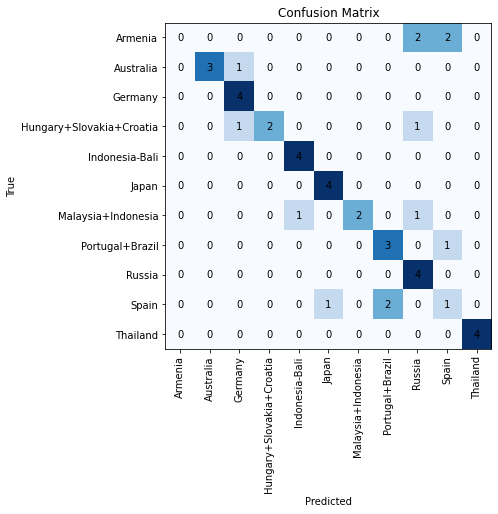

In [23]:
# labels = [test_dataset.countries[t] for t in list(set(y_pred).union(set(y_true)))]
labels = list(test_dataset.countries.values())

plt.figure(figsize=(6,6))
plot_confusion_matrix(y_true, y_pred, labels)

The confusion matrix reveals some additional insights.

The worst performance is associated with Armenia. The reason is that it is the country with far less samples in the dataset, having only 3 pictures in the training dataset. As consequence, it is likely to have room for improvement by adding more pictures to the dataset.

On the other hand, the countries with the most samples (Germany, Russia and Thailand) show altogether good accuracies.

Moreover, Spain presented some misclassifications with Portugal+Brazil and vice-versa. Indeed, their temples share very similar styles, probably due to cultural and geographical proximities. The same problem of similar cultures happen less often to other pair of countries (ie: Russia and Hungary+Slovakia+Croatia, Indonesia-Bali and Malaysia+Indonisia).

## Test Samples

Let's plot all samples from the test dataset in order to further inspect the misclassifications and look for more insights.

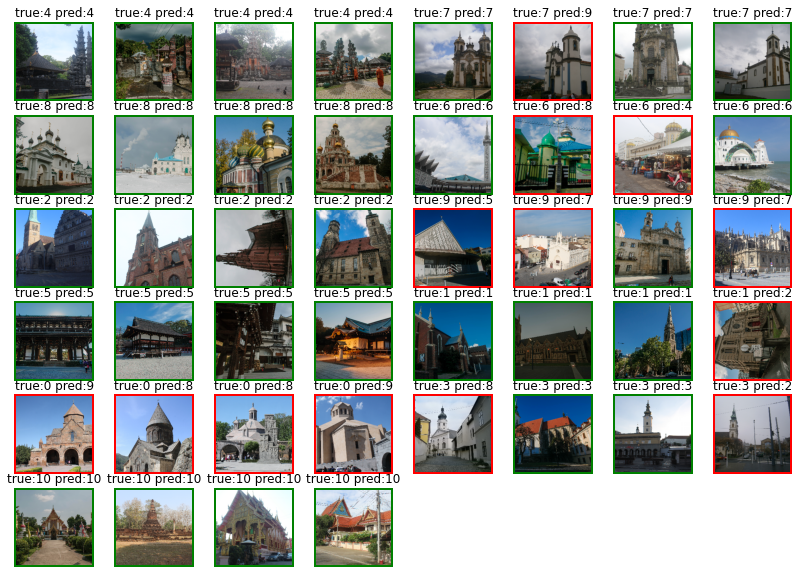

In [25]:
n_test = len(test_dataset)
indices = range(n_test)
plt.figure(figsize=(14, 10))
test_dataset.plot_booth(indices, y_pred, cols=stratified_k * 2)

Even though some images are rotated, it seems that the classification performance is not particularly worst in these cases. In fact, the original ResNet18 works the same for images upwards or rotated. Additionally, rotation was applied during the data augmentation, which helped to make it even more robust to rotations.

Additionally, the observation about the cultural proximity explained in the "Confusion Matrix" session is confirmed as one observe see above.

## Validation Samples

For the sake of curiosity, below is presented the similar samples but for the validation dataset in order to reconfirm all the previous comments.

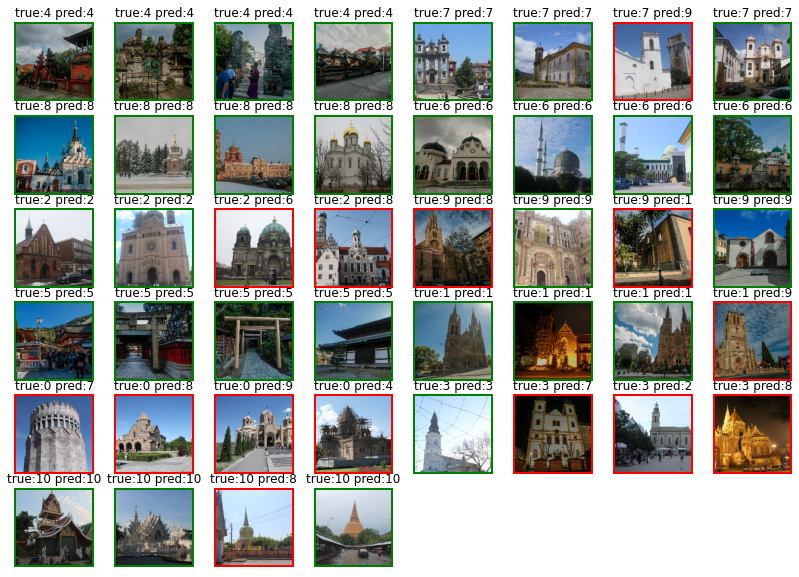

In [26]:
y_pred, y_true = trainer.predict(valid_loader, return_targets=True)

n_valid = len(valid_dataset)
indices = range(n_valid)
plt.figure(figsize=(14, 10))
valid_dataset.plot_booth(indices, y_pred, cols=stratified_k*2)

## Improvement

Based on all insights reported on the "Performance" section, it is concluded that the performance of the classifier can be improved by increasing the size of the training dataset.

Therefore, it is recommended as next step to collect more images of temples and separate them into folder similarly to the provided dataset.

# Production

Below is the suggestion on how to run a standalone script to classify images of temples.

In [1]:
# ------------ MOUNT GOOGLE DRIVE --------------
# import repository (and optionally the dataset)
from google.colab import drive

GITLAB_TOKEN = 'DuYj_iSqRGrYtybZLMRs'
GITLAB_PROJECT = 'diogo-dutra-2'
GITLAB_OWNER = 'screening'
GITLAB_URL = f'https://gitlab-ci-token:{GITLAB_TOKEN}' + \
              f'@git.toptal.com/{GITLAB_OWNER}/{GITLAB_PROJECT}.git'

MODULE_DESTINATION = 'repo'

!rm -rf $GITLAB_PROJECT
!rm -rf $MODULE_DESTINATION
!git clone $GITLAB_URL
!mv $GITLAB_PROJECT $MODULE_DESTINATION

drive.mount('/content/drive', force_remount=True)

# ------------ RUN THE STANDALONE SCRIPT --------------
# model = 'drive/MyDrive/pytorch_boilerplate/2021-03-01_13:56:29.336765-05:00/'
# model += 'model.pth'
model = 'repo/model/model.pth'

folder = './drive/MyDrive/train_small'

!python repo/temple_country.py --folder $folder --model $model

Cloning into 'diogo-dutra-2'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 316 (delta 57), reused 52 (delta 38), pack-reused 223
Receiving objects: 100% (316/316), 41.86 MiB | 7.89 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Mounted at /content/drive
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100% 44.7M/44.7M [00:00<00:00, 258MB/s]
6 images found.
Countries saved on file results.csv
